# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [1]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import opendatasets as od
from torchvision import datasets, transforms
import zipfile
# import helper

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [3]:
import sys
sys.path.append('/content/helper_module.py')
import helper_module

Download and Extract data

In [4]:
od.download('https://www.kaggle.com/c/dogs-vs-cats')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tnnz20
Your Kaggle Key: ··········


100%|██████████| 812M/812M [00:03<00:00, 270MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


In [5]:
local_train_zip = '/content/dogs-vs-cats/train.zip'

def extract_zip(local_zip):
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content/')
  zip_ref.close()

extract_zip(local_train_zip)

In [7]:
import os
import shutil


root_train_dir = './Cat_dog_data/train'
root_test_dir = './Cat_dog_data/test'

def create_dirs(root_dir):
# Empty directory to prevent FileExistsError is the function is run several times
  if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

  # Create new folder
  cat_dir = ['cat', 'dog']
  for dir in cat_dir:
    try:
      new_dir = os.path.join(root_dir, dir)
      os.makedirs(new_dir)
      print(f"Directory {new_dir} created successfully")
    except OSError as error:
      print(error)

create_dirs(root_train_dir)
create_dirs(root_test_dir)

Directory ./Cat_dog_data/train/cat created successfully
Directory ./Cat_dog_data/train/dog created successfully
Directory ./Cat_dog_data/test/cat created successfully
Directory ./Cat_dog_data/test/dog created successfully


Move file to `/Cat_dog_data/train` and separate with labels

In [9]:
import random
base_dir = './train'

def copy_file(base_dir, root_dir, dest_dir, type_dir):
  for file_name in dest_dir:
    target_dir = os.path.join(root_dir, type_dir)
    copied_file = os.path.join(base_dir, file_name)
    shutil.copy(copied_file, target_dir)

def split_file(base_dir, split_size):

  temp_cat = []
  temp_dog = []
  for file_name in os.listdir(base_dir):
    split_name = file_name.split('.')[0]
    if split_name == 'cat':
      temp_cat.append(file_name)
    else:
      temp_dog.append(file_name)
  
  # Create split point
  split_point_cat = int(len(temp_cat) * split_size)
  split_point_dog = int(len(temp_dog) * split_size)

  # Shuffle list
  shuffle_list_cat = random.sample(temp_cat, len(temp_cat))
  shuffle_list_dog = random.sample(temp_dog, len(temp_dog))

  # Split 
  train_cat = shuffle_list_cat[:split_point_cat]
  test_cat = shuffle_list_cat[split_point_cat:]

  train_dog = shuffle_list_dog[:split_point_dog]
  test_dog = shuffle_list_dog[split_point_dog:]

  root_dir = './Cat_dog_data/'
  copy_file(base_dir, root_dir, train_cat, type_dir='train/cat')
  copy_file(base_dir, root_dir, test_cat, type_dir='test/cat')
  copy_file(base_dir, root_dir, train_dog, type_dir='train/dog')
  copy_file(base_dir, root_dir, test_dog, type_dir='test/dog')


split_file(base_dir, split_size=0.9)

In [10]:
import pathlib
PATH = './Cat_dog_data'
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f'Total image from this datasets : {image_count}')
for i in os.listdir(data_dir):
  image_count = len(list(data_dir.glob(f'{i}/*/*.jpg')))
  print(f'Total image from this {i} : {image_count}')

Total image from this datasets : 25000
Total image from this test : 2500
Total image from this train : 22500


The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has its own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

In [11]:
data_dir_train = '/content/Cat_dog_data/train'

# TODO: compose transforms here
transform = transforms.Compose([
                               transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()
                          ])

# TODO: create the ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)

# TODO: use the ImageFolder dataset to create the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

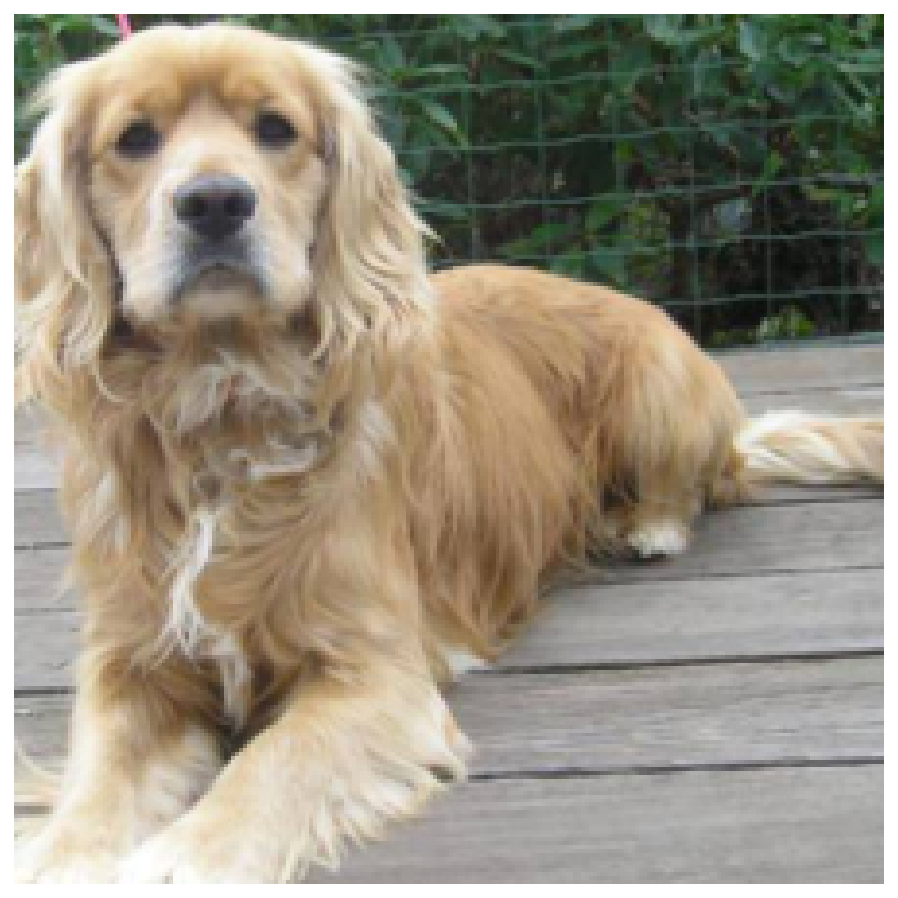

In [12]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper_module.imshow(images[0], normalize=False)

If you loaded the data correctly, you should see something like this (your image will be different):

<img src='assets/cat_cropped.png' width=244>

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

>**Exercise:** Define transforms for training data and testing data below. Leave off normalization for now.

In [13]:
data_dir = 'Cat_dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])
                                       ])

test_transforms = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()
                                      ])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


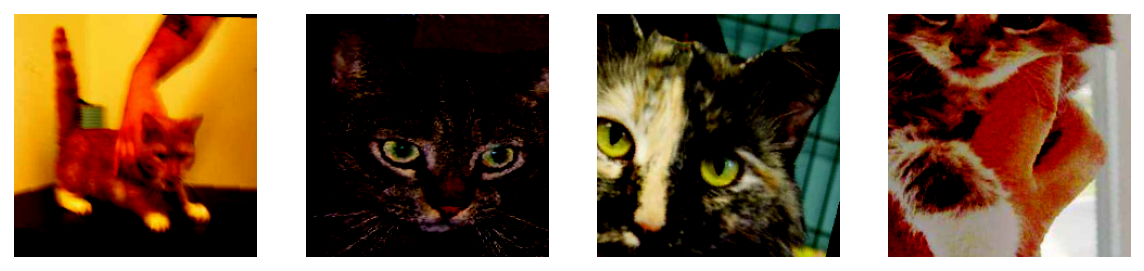

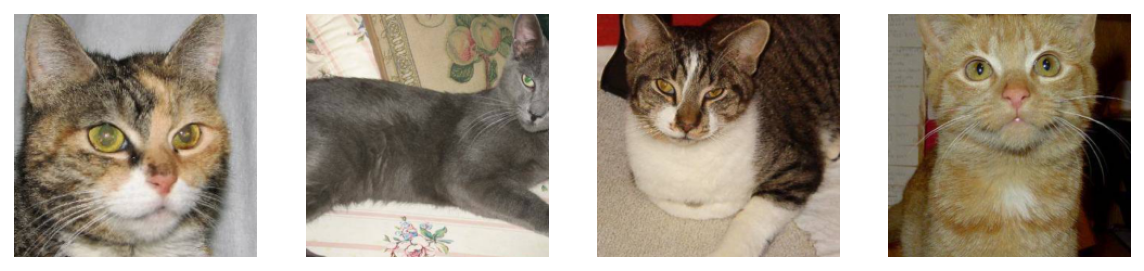

In [14]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper_module.imshow(images[ii], ax=ax, normalize=False)
    
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper_module.imshow(images[ii], ax=ax, normalize=False)

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

<center>Testing examples:</center>
<img src='assets/test_examples.png' width=500px>

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [32]:
# Optional TODO: Attempt to build a network to classify cats vs dogs from this dataset
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
    self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
    self.fc2 = nn.Linear(in_features=500, out_features=50)
    self.fc3 = nn.Linear(in_features=50, out_features=2)

    self.dropout = nn.Dropout(p=0.4)

  def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
        
        X = X.view(X.shape[0], -1)
        X = self.dropout(F.relu(self.fc1(X)))
        X = self.dropout(F.relu(self.fc2(X)))
        X = F.log_softmax(self.fc3(X), dim=1)
        
        return X

In [35]:
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Classifier().to(device)
losses = []
accuracies = []
epoches = 5
start = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(epoches):
    epoch_loss = 0
    epoch_accuracy = 0
    for images, labels in trainloader:
      images = images.cuda()
      labels = labels.cuda()
      preds = model(images)
      loss = criterion(preds, labels)

      optimizer.zero_grad()  
      loss.backward()
      optimizer.step()
      
      epoch_loss += loss
      accuracy = ((preds.argmax(dim=1) == labels).float().mean())
      epoch_accuracy += accuracy
        

    epoch_accuracy = epoch_accuracy/len(trainloader)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(trainloader)
    losses.append(epoch_loss)

    result = f'''Epoch: {epoch+1}
    train loss: {epoch_loss:.4f}
    train accracy: {epoch_accuracy:.4f}
    time: {int(time.time() - start)}
    '''
    print(result)

    with torch.no_grad():
      model.eval()

      val_epoch_loss = 0
      val_epoch_accuracy = 0
      for val_images, val_labels in testloader:
          val_images = val_images.cuda()
          val_labels = val_labels.cuda()
          val_preds = model(val_images)
          val_loss = criterion(val_preds, val_labels)

          val_epoch_loss += val_loss
          val_accuracy = ((val_preds.argmax(dim=1) == val_labels).float().mean())
          val_epoch_accuracy += val_accuracy
    
    model.train()

    val_epoch_accuracy = val_epoch_accuracy/len(testloader)  
    val_epoch_loss = val_epoch_loss / len(testloader)
        
    result = f'''Epoch: {epoch+1}  
        valid loss: {val_epoch_loss:.4f} 
        valid accracy: {val_epoch_accuracy:.4f} 
        time: {int(time.time() - start)}
        '''
    print(result)

Epoch: 1 \ train loss: 2.5403     train accracy: 0.9781 \ time: 119
    
Epoch: 1  
        valid loss: 126.9284 
        valid accracy: 0.5055 
        time: 131
        
Epoch: 2 \ train loss: 2.1259     train accracy: 0.8043 \ time: 250
    
Epoch: 2  
        valid loss: 3.7669 
        valid accracy: 0.5055 
        time: 262
        
Epoch: 3 \ train loss: 0.7926     train accracy: 0.7296 \ time: 382
    
Epoch: 3  
        valid loss: 1.0441 
        valid accracy: 0.5055 
        time: 394
        
Epoch: 4 \ train loss: 0.7096     train accracy: 0.6280 \ time: 517
    
Epoch: 4  
        valid loss: 0.8347 
        valid accracy: 0.5055 
        time: 529
        
Epoch: 5 \ train loss: 0.7241     train accracy: 0.5588 \ time: 651
    
Epoch: 5  
        valid loss: 0.7423 
        valid accracy: 0.5055 
        time: 663
        
